In [12]:
# Bending rigidity

import numpy as np
from scipy.integrate import solve_bvp
import matplotlib
import matplotlib.pyplot as plt
from FunctionDefinitions.endoInit import endoInit
from math import sin, cos, tan, pi, tanh, ceil
import pandas as pd
from scipy import interpolate
from random import sample
from math import isclose
import itertools

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [13]:
# import parameters that were previously explored and sample new parameters to explore

global first_run 
first_run = False

param_combos = pd.read_csv('Test_parameter_combos_delta.csv')
num_to_explore = 5

if first_run == False:
    param_combos_explored = pd.read_csv('Params_explored_delta.csv')
    param_combos = param_combos.drop(param_combos_explored.indices, axis = 0)
    indices_to_explore = sample(set(param_combos.index), num_to_explore)
    param_combos_to_explore = param_combos.loc[indices_to_explore]
    param_combos_to_explore['indices'] = indices_to_explore

elif first_run == True:
    indices_to_explore = sample(range(0, len(param_combos)), num_to_explore)
    param_combos_to_explore = param_combos.loc[indices_to_explore]
    param_combos_to_explore['indices'] = indices_to_explore
    
else: 
    print('Error: It is unclear if this is the first run of parameter space sampling')

In [14]:
param_combos_explored = pd.read_csv('Params_explored_delta.csv')
param_combos_explored.tail()

,lam_dim,lam_dim_id,rad,rad_id,pressure_dim,pressure_dim_id,simulation_area,patch_area,delta,delta_id,k0,k0_id,indices
375,0.134793,26.0,440.625,35.0,0.0,NaN,2.195789e+07,2.439766e+06,0.396552,7.0,320.0,NaN,33037.0
376,0.023276,4.0,369.375,29.0,0.0,NaN,1.543076e+07,1.714529e+06,0.202586,2.0,320.0,NaN,5792.0
377,0.018207,3.0,131.875,9.0,0.0,NaN,1.966878e+06,2.185419e+05,0.280172,4.0,320.0,NaN,3964.0
378,0.073966,14.0,25.000,0.0,0.0,NaN,7.068583e+04,7.853982e+03,0.241379,3.0,320.0,NaN,17223.0
379,0.028345,5.0,369.375,29.0,0.0,NaN,1.543076e+07,1.714529e+06,0.900862,20.0,320.0,NaN,7040.0


In [15]:
param_combos_to_explore

,lam_dim,lam_dim_id,rad,rad_id,pressure_dim,pressure_dim_id,simulation_area,patch_area,delta,delta_id,k0,k0_id,indices
13258,0.053690,10.0,393.125,31.0,0.0,NaN,1.747888e+07,1.942098e+06,1.211207,28.0,320.0,NaN,13258
9610,0.038483,7.0,416.875,33.0,0.0,NaN,1.965459e+07,2.183844e+06,0.512931,10.0,320.0,NaN,9610
2646,0.013138,2.0,96.250,6.0,0.0,NaN,1.047741e+06,1.164156e+05,0.357759,6.0,320.0,NaN,2646
14678,0.058759,11.0,476.250,38.0,0.0,NaN,2.565207e+07,2.850230e+06,0.435345,8.0,320.0,NaN,14678
18425,0.073966,14.0,500.000,40.0,0.0,NaN,2.827433e+07,3.141593e+06,0.318966,5.0,320.0,NaN,18425


In [16]:
###### Function definitions
def dXdt(t, X):
    # spontaneous curvature
    c = 0.5*C0*(1 - np.tanh(g*(t - a0))) 

    # derivative of spontaneous curvature
    dc = 0.5*C0*g*(np.tanh(g*(t - a0))**2 - 1)

    # bending modulus
    b = 1 + 0.5*(delta-1)*(1 - np.tanh(g*(t - a0))) # By the form of this definition of k it's effectively non-dimensionalized.
                                                    # Using delta, we tune the proportion offset of the bare and coated membrane
                                                    # rigidities, but not the actual values. So if the coated region has a rigidity
                                                    # 10x the rigidity of the bare membrane, choose delta = 10. If it has a rigidity
                                                    # half that of the bare membrane, choose delta = .5.

    # derivative of bending modulus
    db = 0.5*(delta-1)*g*(np.tanh(g*(t - a0))**2 - 1)

    # Derivative of Gaussian modulus
    dkg = 0.5*delkG*g*(np.tanh(g*(t - a0))**2 - 1) # This is essentially the same as dk except we just didn't define kg.

    # Second derivative of Gaussian modulus
    ddkg = delkG*(g**2)*np.tanh(g*(t - a0))*(1 - np.tanh(g*(t - a0))**2)
   
    # p_non_dim = (pressure_dim*(R0**3))/k0     # This would be if pressure were uniform
    p_non_dim = .5*((pressure_dim*(R0**3))/k0)*(1 - np.tanh(g*(t - a0)))

    return np.vstack((np.cos(X[2])/X[0], # x
                      np.sin(X[2])/X[0], # y
                      (2*X[0]*X[3]-np.sin(X[2]))/(X[0]**2), # psi
                      X[4]/X[0]**2 + dc - db/b*(X[3] - c), # h
                      p_non_dim/b + 2*X[3]*((X[3]-c)**2 + X[5]/b) - 2*(X[3]-c)*(X[3]**2 + (X[3]-np.sin(X[2])/X[0])**2) - db/b*X[4] - (ddkg/b)*X[0]*np.sin(X[2]) - (dkg/b)*np.cos(X[2])*(2*X[3] - np.sin(X[2])/X[0]),
                      -db*((X[3] - c)**2) + 2*b*(X[3] - c)*dc - dkg*(X[3]**2 - (X[3] - np.sin(X[2])/X[0])**2)
                     ))


# These are set I as in Behzadan & Rangamani
def bc(Xa, Xb):
    ds = 0.0001 # small offset to prevent division by 0
    return np.array([ Xa[0] - ds,
            Xb[1],
            Xa[2],
            Xb[2],
            Xa[4],
            Xb[5] - lam
            ])

def find_bud_neck(sol, value: -pi/2):
    # find locations where psi is about pi/2 (value)
    array = np.asarray(sol[2][:])
    potential_idx = np.where((np.abs(array - value)) <= .01)[0]
    ind_min_x = np.argmin(np.asarray(sol[0][potential_idx]))
    idx = potential_idx[ind_min_x]
    return idx


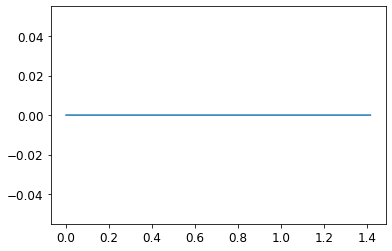

In [17]:
# Initialize a flat membrane solution

# Mesh: it's important to have a greater mesh density near the pole since the largest shape transformations happen here. Therefore we square the mesh.
mesh_step = 1/2000
mesh_end = 1 
mesh = np.arange(0,mesh_end + mesh_step,mesh_step)**2 # mesh - meshing for the domain, runs from 0 to 1, i.e. 0:0.01:1

# Parameters
lam_dim = .002                         # membrane tension at the boundary, in units of pN/nm
k0 = 320                               # rigidity of bare membrane, in units of pN*nm
R0 = 20                                # R0 - nondimensionalization length
C0 = -.02                              # nm^-1 preferred membrane curvature
lam = lam_dim*(R0**2)/k0
              
delta = 1                              # For non dimensional problem, delta describes the proportion difference
                                       # of the coated regions bending modulus from the uncoated membrane (k0).
delkG = 0                              
pressure_dim = 0                           

global g
g = 20                                 # This is basically the steepness of the curvature transition

# Define patch area based on goal MP radius
rad = 50
A = 4*pi*(3*rad)**2 # Dimensional patch area  
A0 = 4*pi*rad**2 # Dimensional coat area
a = A/(2*pi*R0**2) # Nondimensional patch area 
a0 = A0/(2*pi*R0**2) # Nondimensional coat area
t = a*mesh           
  
initSol = endoInit(a, mesh, lam, k0, R0) # Agrawal is for arc parameterization; we are using the area parameterization
plt.plot(initSol[0], initSol[1])

In [18]:
# Create a dataframe to store both parameters and resulting curve in. 
# Additionally, we'll input two metrics: neck radius and whether psi exceeds 90 degrees (an omega shaped bud)
# Finally, we'll also create a indicating which parameter combo we're using.
# This requires each parameter combo has a unique id number.

# Number of data points that we'll interpolate the curve onto to reduce storage needs
interp_num = 50

column_names = ['Param_id', 'C0', 'C0_id', 'rad', 'rad_id', 'delta', 'delkG', 'F0', 'k0', 'lam_dim', 'lam_dim_id', 'pressure_dim', 'pressure_dim_id', 'omega', 'neck_rad'] # if true, omega = 1, if false omega = 0

x_names = []
y_names = []
for i in np.arange(0,interp_num):
    x_names.append(str('x' + str(i)))
    y_names.append(str('y' + str(i)))

column_names = column_names + x_names + y_names
column_names

run_data = pd.DataFrame(index = np.array([]),columns = column_names)
run_data



,Param_id,C0,C0_id,rad,rad_id,delta,delkG,F0,k0,lam_dim,...,y40,y41,y42,y43,y44,y45,y46,y47,y48,y49


In [19]:
# The goal of this function is to maintain a history of "initial solutions" in working memory so that we can descend on curvature if the last initial guess doesn't
# yield a convergent next solution

def initSolPrev(sol, previous_initSol_old, previous_initSol_new, ind_num):
    if ind_num == 0:
        initSol_new = endoInit(a, t, lam, k0, R0)
        initSol_old = endoInit(a, t, lam, k0, R0)
    else:
        initSol_old = previous_initSol_new # Rewrite the old init sol with the last iterations new one -- this means we'll have initSols 2 time steps in history
        
        # All this else jazz is about initializing the solution with the previous results; apparently you can't just plug in the bvp solution
        # but there's probably a workaround I've not figured out yet.
        temp0 = sol.y[0]
        temp1 = sol.y[1]
        temp2 = sol.y[2]
        temp3 = sol.y[3]
        temp4 = sol.y[4]
        temp5 = sol.y[5]

        initSol = endoInit(a, t, lam, k0, R0)
        # Use interpolation to put the old solution onto the new x-axis
        f = interpolate.interp1d(temp0, temp1, fill_value="extrapolate")
        xnew = initSol[0]
        initSol[1] = f(xnew)
        f = interpolate.interp1d(temp0, temp2, fill_value="extrapolate")
        initSol[2] = f(xnew)
        f = interpolate.interp1d(temp0, temp3, fill_value="extrapolate")
        initSol[3] = f(xnew)
        f = interpolate.interp1d(temp0, temp4, fill_value="extrapolate")
        initSol[4] = f(xnew)
        f = interpolate.interp1d(temp0, temp5, fill_value="extrapolate")
        initSol[5] = f(xnew)
        
        initSol_new = initSol
        
    return initSol_old, initSol_new

In [20]:
loop_number = 100
C0_ran = np.linspace(0, .07, loop_number)

def runDataStructure(interp_num = 50):
    column_names = ['Param_id', 'C0', 'C0_id', 'rad', 'rad_id', 'delta', 'delkG', 'F0', 'k0', 'lam_dim', 'lam_dim_id', 'pressure_dim', 'pressure_dim_id', 'omega', 'neck_rad'] # if true, omega = 1, if false omega = 0
    
    x_names = []
    y_names = []
    for i in np.arange(0,interp_num):
        x_names.append(str('x' + str(i)))
        y_names.append(str('y' + str(i)))

    column_names = column_names + x_names + y_names
    column_names

    run_data = pd.DataFrame(index = np.array([]),columns = column_names)
    return run_data

In [21]:
def ascendingLoopCurvature(Param_id, lam,lam_dim,lam_dim_id, pressure_dim, pressure_dim_id,  k0, R0, rad, rad_id, delta, A, A0, a, a0, t, C0_ran, run_data):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    # Loop over values of curvature to get a convergent solution for the parameter set
    loop_number = len(C0_ran)

    for i in np.arange(0,loop_number):
        list_data = []
        global C0
        C0 = -1*R0*C0_ran[i]
        C0_id = i
        
        if i == 0: # This is strictly so that we have a value to plug into initSolPrev -- it shouldn't have a behaviour for i == 0
            sol = np.nan
            initSol_old = np.nan
            initSol_new = np.nan
        
        # Set up initial solution
        initSol_old, initSol_new = initSolPrev(sol, initSol_old, initSol_new, i)
        initSol = initSol_new
            
        # Solve the bvp
        sol = solve_bvp(dXdt, bc, t, initSol, tol = 1e-2, max_nodes = 1000*len(t))
    
        # Print an error and break the loop if we get an error -- this is the point where we'd iterate down curvature using descendingLoopCurvature
        desc_run_data = pd.DataFrame([])
        if sol.status != 0:
            print("WARNING: sol.status is %d" % sol.status)
            print(sol.message)
            print(C0_ran[i])
            ax1.set_title('Equilibrium solutions depend on curvature (ascending -- break)', fontsize = BIGGER_SIZE)
            ax2.set_xlabel('Length (nm)')
            ax1.set_ylabel('Height (nm)')
            ax2.set_ylabel('Height (nm)')
            plt.show()
            
            # The first initial solution will be the solution prior to the one that threw the error
            initSol = initSol_old
            # Sort the curvature values to loop over from largest to smallest (0)
            if i == 0:
                print('Error here errored out on first increment of curvature')
                break
                
            C0_ran_back = -1*np.sort(-1*np.linspace(0, C0_ran[i-1], i-1))
            
            desc_run_data = descendingLoopCurvature(Param_id, lam,lam_dim,lam_dim_id,  pressure_dim, pressure_dim_id, k0, R0, rad, rad_id, delta, A, A0, a, a0, t, C0_ran_back, initSol)
            break
        
        # As long as we got a convergent solution (status = 0) then record all the details of the run
        else:
            list_data = [Param_id, C0, C0_id, rad, rad_id, delta, delkG, F0, k0, lam_dim, lam_dim_id, pressure_dim, pressure_dim_id] #, 'omega', 'neck_rad']
            
            # Check to see if the curve ever doubles back on itelf using an approximate derivative, indicating an omega shaped bud
            xsol = sol.y[0]
            
            # interpolate to reduce the size of the data
            fy = interpolate.interp1d(np.arange(0,len(sol.y[0])), sol.y[1][:]*R0, fill_value="extrapolate") # interpolating on the index should work in theory, but then the question is how do we reconstitute the correct x vals... Probably need to interpolate that on the index too
            xnew = np.linspace(0,len(sol.y[0]), interp_num)
            reduced_y = fy(xnew)
            fx = interpolate.interp1d(np.arange(0,len(sol.y[0])), sol.y[0][:]*R0, fill_value="extrapolate")
            reduced_x = fx(xnew)

            # Compute the derivative of the curve on the interpolated points    
            pd_dydx = pd.Series(np.gradient(sol.y[1][:]*R0, sol.y[0][:]*R0)).round(decimals = 3) 

            # Determine the sign changes of the derivative to look for omega type, coded as 1
            sign_test = list(itertools.groupby(list(pd_dydx), lambda x: x > 0))
            sign_test_deriv = []
            for st in sign_test:
                sign_test_deriv.append(st[0]) # append only the True False value, not the iterator object
            
            # Also determine the sign changes of curvature -- for an omega bud should have - +
            sign_test = list(itertools.groupby(list(sol.y[3][:]), lambda x: x > 0))
            sign_test_curv = []
            for st in sign_test:
                sign_test_curv.append(st[0]) # append only the True False value, not the iterator object
            
            # Also determine the sign changes of psi -- for an omega bud should have - + ....?
            sign_test = list(itertools.groupby(list(sol.y[2][:]), lambda x: x > 0))
            sign_test_psi = []
            for st in sign_test:
                sign_test_psi.append(st[0]) # append only the True False value, not the iterator object
            
            
            if (np.abs(sol.y[2][:])).max() > np.pi/2:  # Check if psi is ever larger than pi/2
                ax1.scatter(sol.y[0][:]*R0, sol.y[1][:]*R0, alpha = .01, c = 'black', marker = '.')
                ax1.scatter(reduced_x, reduced_y, alpha = .5, c = 'blue')
                list_data = list_data + [1] # adding the one is our indicator that this is an omega shaped bud

                # Find the bud neck and graphically mark it.
                try:
                    idx = find_bud_neck(sol.y, -pi/2)
                    ax1.scatter(sol.y[0][idx]*R0, sol.y[1][idx]*R0, c = 'red', marker = 'x', label = " Psi ~ pi/2")
                    neck_rad = sol.y[0][idx] # document the diameter of the neck
                except:
                    print('Couldnt find bud neck radius')
                    neck_rad = np.nan
                
                # record neck radius
                list_data = list_data + [neck_rad]
                
                # Plot the derivative of the curve
                #ax3.plot(np.arange(0,len(pd_dydx)), pd_dydx, c = 'blue', alpha = .5)
                
                # Plot the psi is 2 curvature is 3 of the curve
                ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'blue', alpha = .5) # psi 
                #ax3.plot(sol.y[0][:]*R0, sol.y[3][:]/R0, c = 'blue', alpha = .5) # curvature
            
            # Attempted sub classifying hill shapes; this was unhelpful, so all -1 values were replaced after the fact with a 0
            elif (sign_test_deriv == [False] and sign_test_curv == [False, True]) or sign_test_deriv == [False] and sign_test_curv == [False, True, False]: 
                ax1.scatter(sol.y[0][:]*R0, sol.y[1][:]*R0, alpha = .01, c = 'black', marker = '.')
                ax1.scatter(reduced_x, reduced_y, alpha = .5, c = 'green')
                # adding the zero is our indicator that this is not an omega shaped bud
                list_data = list_data + [0] 
                # ...and there is no neck to measure the radius of
                list_data = list_data + [np.nan]
                
                # Plot the psi is 2, curvature is 3 of the curve
                ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'green', alpha = .5) # psi 
                #ax3.plot(sol.y[0][:]*R0, sol.y[3][:]/R0, c = 'green', alpha = .5) # curvature
            
            else:
                ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'red', alpha = .5)
                # ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'red', alpha = .5) # psi 
                #ax3.plot(sol.y[0][:]*R0, sol.y[3][:]/R0, c = 'red', alpha = .5) # curvature

                # It's not an omega shaped bud, or a hill (per this attempt at classification...) so add a -1 indicator
                list_data = list_data + [-1]
                # ...and there is no neck to measure the radius of
                list_data = list_data + [np.nan]
                ax2.plot(sol.y[0][:]*R0, sol.y[1][:]*R0, alpha = .15, c = 'black')
                
            # append the x locations
            list_data = np.append(np.array(list_data), reduced_x)
            # append the y locations
            list_data = np.append(list_data, reduced_y)

            # Now we need to put list_data into the dataframe
            run_data = run_data.append(pd.DataFrame([list_data], columns = column_names, index = [0]))
    
    ax1.set_title('Equilibrium solutions depend on curvature (ascending)', fontsize = BIGGER_SIZE)
    ax2.set_xlabel('Length (nm)')
    ax1.set_ylabel('Height (nm)')
    ax2.set_ylabel('Height (nm)')
    #plt.savefig('test.png', bbox_inches="tight")
    plt.show()

    run_data.reset_index(drop = True)      
            
    # need to add run_data and desc_run_data here
    if desc_run_data.shape == (0,0): 
        print('desc_run_data is empty')
    else:
        run_data = run_data.append(desc_run_data)
        
    if first_run == False:
        run_data_old = pd.read_csv('run_data_pressure.csv')
        run_data_new = run_data_old.append(run_data)
        run_data_new.to_csv("run_data_pressure.csv", index = False)
        
        run_data = run_data_new
    elif first_run == True:
        run_data.to_csv("run_data_pressure.csv", index = False)
        run_data = run_data
    else:
        print('Error: It is unclear if this is the first run of parameter space sampling')
    return

            
            
def descendingLoopCurvature(Param_id, lam,lam_dim,lam_dim_id, pressure_dim, pressure_dim_id,  k0, R0, rad, rad_id, delta, A, A0, a, a0, t, C0_ran, initSol):
    desc_run_data = runDataStructure(interp_num = 50)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    # Loop over values of curvature to get a convergent solution for the parameter set
    loop_number = len(C0_ran)

    for i in np.arange(0,loop_number):
        list_data = []
        global C0
        C0 = -1*R0*C0_ran[i]
        C0_id = i
   
        # Solve the bvp
        sol = solve_bvp(dXdt, bc, t, initSol, tol = 1e-2, max_nodes = 100*len(t))
        
        if sol.status != 0:
            print("DESCENDING CURVATURE ERROR")
            print("WARNING: sol.status is %d" % sol.status)
            print(sol.message)
            break
        else:
            # Create the new initSol based on previous solution
            temp0 = sol.y[0]
            temp1 = sol.y[1]
            temp2 = sol.y[2]
            temp3 = sol.y[3]
            temp4 = sol.y[4]
            temp5 = sol.y[5]

            initSol = endoInit(a, t, lam, k0, R0)
            # Use interpolation to put the old solution onto the new x-axis
            f = interpolate.interp1d(temp0, temp1, fill_value="extrapolate")
            xnew = initSol[0]
            initSol[1] = f(xnew)
            f = interpolate.interp1d(temp0, temp2, fill_value="extrapolate")
            initSol[2] = f(xnew)
            f = interpolate.interp1d(temp0, temp3, fill_value="extrapolate")
            initSol[3] = f(xnew)
            f = interpolate.interp1d(temp0, temp4, fill_value="extrapolate")
            initSol[4] = f(xnew)
            f = interpolate.interp1d(temp0, temp5, fill_value="extrapolate")
            initSol[5] = f(xnew)

            # Record the parameters used in list data object -- since we're descending we record the negative of curvature index
            list_data = [Param_id, C0, int(-1*C0_id), rad, rad_id, delta, delkG, F0, k0, lam_dim, lam_dim_id, pressure_dim, pressure_dim_id] #, 'omega', 'neck_rad']

            
            fy = interpolate.interp1d(np.arange(0,len(sol.y[0])), sol.y[1][:]*R0, fill_value="extrapolate") # interpolating on the index should work in theory, but then the question is how do we reconstitute the correct x vals... Probably need to interpolate that on the index too
            xnew = np.linspace(0,len(sol.y[0]), interp_num)
            reduced_y = fy(xnew)
            fx = interpolate.interp1d(np.arange(0,len(sol.y[0])), sol.y[0][:]*R0, fill_value="extrapolate")
            reduced_x = fx(xnew)
            
            # Compute the derivative of the curve on the interpolated points    
            pd_dydx = pd.Series(np.gradient(sol.y[1][:]*R0, sol.y[0][:]*R0)).round(decimals = 3) 

            # Determine the sign changes of the derivative to look for omega type, coded as 1
            sign_test = list(itertools.groupby(list(pd_dydx), lambda x: x > 0))
            sign_test_deriv = []
            for st in sign_test:
                sign_test_deriv.append(st[0]) # append only the True False value, not the iterator object
            
            # Also determine the sign changes of curvature -- for an omega bud should have - +
            sign_test = list(itertools.groupby(list(sol.y[3][:]), lambda x: x > 0))
            sign_test_curv = []
            for st in sign_test:
                sign_test_curv.append(st[0]) # append only the True False value, not the iterator object
            
            #print(sign_test_curv)
            if (np.abs(sol.y[2][:])).max() > np.pi/2: 
                ax1.scatter(sol.y[0][:]*R0, sol.y[1][:]*R0, alpha = .01, c = 'black', marker = '.')
                ax1.scatter(reduced_x, reduced_y, alpha = .5, c = 'blue')
                list_data = list_data + [1] # adding the one is our binary indicator that this is an omega shaped bud

                # Find the bud neck and graphically mark it.
                try:
                    idx = find_bud_neck(sol.y, -pi/2)
                    ax1.scatter(sol.y[0][idx]*R0, sol.y[1][idx]*R0, c = 'red', marker = 'x', label = " Psi ~ pi/2")
                    neck_rad = sol.y[0][idx] # document the diameter of the neck
                except:
                    print('Couldnt find bud neck radius')
                    neck_rad = np.nan
                
                # record neck radius
                list_data = list_data + [neck_rad]
                
                # Plot the derivative of the curve
                #ax3.plot(np.arange(0,len(pd_dydx)), pd_dydx, c = 'blue', alpha = .5)
                
                # Plot the psi is 2 curvature is 3 of the curve
                ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'blue', alpha = .5) # psi 
                #ax3.plot(sol.y[0][:]*R0, sol.y[3][:]/R0, c = 'blue', alpha = .5) # curvature
            
            # classify hill shape
            elif (sign_test_deriv == [False] and sign_test_curv == [False, True]) or sign_test_deriv == [False] and sign_test_curv == [False, True, False]: 
                ax1.scatter(sol.y[0][:]*R0, sol.y[1][:]*R0, alpha = .01, c = 'black', marker = '.')
                ax1.scatter(reduced_x, reduced_y, alpha = .5, c = 'orange')
                # adding the zero is our indicator that this is an omega shaped bud
                list_data = list_data + [0] 
                # ...and there is no neck to measure the radius of
                list_data = list_data + [np.nan]
                
                # Plot the psi is 2, curvature is 3 of the curve
                ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'orange', alpha = .5) # psi 
                #ax3.plot(sol.y[0][:]*R0, sol.y[3][:]/R0, c = 'green', alpha = .5) # curvature
            
            else:
                ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'red', alpha = .5)
                # ax3.plot(sol.y[0][:]*R0, sol.y[2][:], c = 'red', alpha = .5) # psi 
                #ax3.plot(sol.y[0][:]*R0, sol.y[3][:]/R0, c = 'red', alpha = .5) # curvature

                # It's not an omega shaped bud...
                list_data = list_data + [-1]
                # ...and there is no neck to measure the radius of
                list_data = list_data + [np.nan]
                ax2.plot(sol.y[0][:]*R0, sol.y[1][:]*R0, alpha = .15, c = 'black')
                
            # append the x locations
            list_data = np.append(np.array(list_data), reduced_x)
            # append the y locations
            list_data = np.append(list_data, reduced_y)

            # Now we need to put list_data into the dataframe
            desc_run_data = desc_run_data.append(pd.DataFrame([list_data], columns = column_names, index = [0]))
        
    ax1.set_title('Equilibrium solutions depend on curvature (descending)', fontsize = BIGGER_SIZE)
    ax2.set_xlabel('Length (nm)')
    ax1.set_ylabel('Height (nm)')
    ax2.set_ylabel('Height (nm)')
    #plt.savefig('test.png', bbox_inches="tight")
    plt.show()

    desc_run_data.reset_index(drop = True)
    
    return desc_run_data
    
    
    
    
  

13258


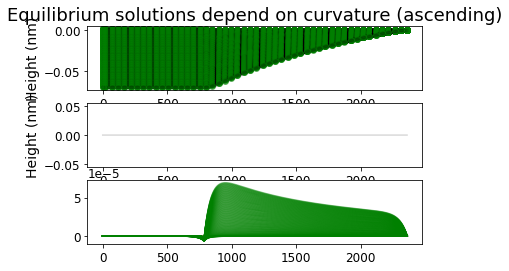

desc_run_data is empty
There was an error in collecting data for parameter  13258
9610


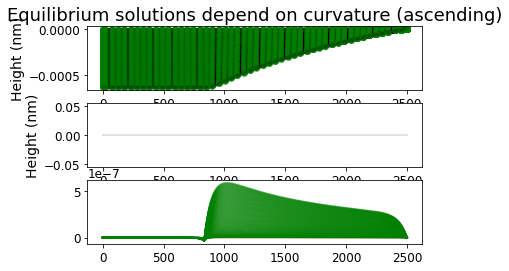

desc_run_data is empty
There was an error in collecting data for parameter  9610
2646


<ipython-input-16-89e44d058f65>:37: RuntimeWarning: overflow encountered in multiply
  (2*X[0]*X[3]-np.sin(X[2]))/(X[0]**2), # psi
<ipython-input-16-89e44d058f65>:37: RuntimeWarning: overflow encountered in square
  (2*X[0]*X[3]-np.sin(X[2]))/(X[0]**2), # psi
<ipython-input-16-89e44d058f65>:37: RuntimeWarning: invalid value encountered in true_divide
  (2*X[0]*X[3]-np.sin(X[2]))/(X[0]**2), # psi
<ipython-input-16-89e44d058f65>:38: RuntimeWarning: overflow encountered in square
  X[4]/X[0]**2 + dc - db/b*(X[3] - c), # h
<ipython-input-16-89e44d058f65>:38: RuntimeWarning: invalid value encountered in multiply
  X[4]/X[0]**2 + dc - db/b*(X[3] - c), # h
<ipython-input-16-89e44d058f65>:39: RuntimeWarning: overflow encountered in square
  p_non_dim/b + 2*X[3]*((X[3]-c)**2 + X[5]/b) - 2*(X[3]-c)*(X[3]**2 + (X[3]-np.sin(X[2])/X[0])**2) - db/b*X[4] - (ddkg/b)*X[0]*np.sin(X[2]) - (dkg/b)*np.cos(X[2])*(2*X[3] - np.sin(X[2])/X[0]),
<ipython-input-16-89e44d058f65>:39: RuntimeWarning: overflow encou

A singular Jacobian encountered when solving the collocation system.
0.021212121212121217


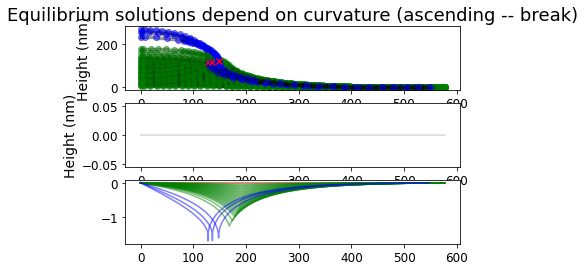

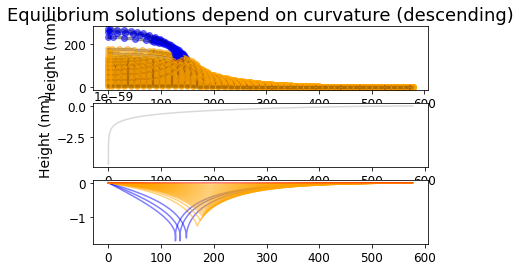

There was an error in collecting data for parameter  2646
14678


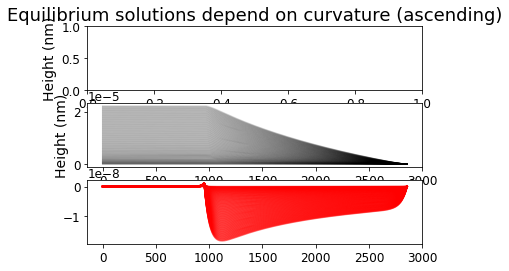

desc_run_data is empty
There was an error in collecting data for parameter  14678
18425


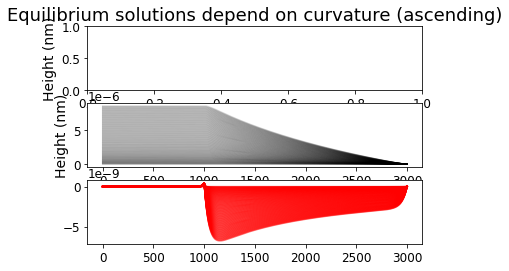

desc_run_data is empty
There was an error in collecting data for parameter  18425


In [22]:
global g
g = 20

F = 0 
loop_number = 100
params = []
non_monotonic = 0 
pars_throw_errors = []
p_c_e = [] # Preliminary list where we store the parameters explored on this round
for j in np.arange(0,len(param_combos_to_explore)):
    
    #fig, (ax1, ax2) = plt.subplots(2, 1)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
    # Block to establish parameters
    param_combos_id = param_combos_to_explore.index[j]
    print(param_combos_id)
    global lam, k0,lam_dim, pressure_dim, R0, rad, F0, delta, pressure_dim
    R0 = 20
    k0 = param_combos_to_explore.iloc[j].k0 
    delta = param_combos_to_explore.iloc[j].delta
    delta_id = param_combos_to_explore.iloc[j].delta_id
    lam_dim = param_combos_to_explore.iloc[j].lam_dim 
    lam_dim_id = param_combos_to_explore.iloc[j].lam_dim_id
    pressure_dim = param_combos_to_explore.iloc[j].pressure_dim
    pressure_dim_id = param_combos_to_explore.iloc[j].pressure_dim_id
    lam = lam_dim*(R0**2)/k0
    rad = param_combos_to_explore.iloc[j].rad
    rad_id = param_combos_to_explore.iloc[j].rad_id
    A = 4*pi*(3*rad)**2 # Dimensional patch area  
    A0 = 4*pi*rad**2 # Dimensional coat area
    a = A/(2*pi*R0**2) # Nondimensional patch area 
    a0 = A0/(2*pi*R0**2) # Nondimensional coat area
    t = a*mesh    
    C0_ran = np.linspace(0, .07, loop_number) # 1/(rad)
    F0_ran = np.linspace(0, F, loop_number)
    F0 = 0
    recursion_num = 0
    
    run_data_structure = runDataStructure()
    try:
        ascendingLoopCurvature(param_combos_id, lam,lam_dim,lam_dim_id, pressure_dim_id, pressure_dim, k0, R0, rad, rad_id, delta, A, A0, a, a0, t, C0_ran, run_data)
    except:
        pars_throw_errors.append(param_combos_id)
        print("There was an error in collecting data for parameter ", str(param_combos_id))
        
    p_c_e.append(param_combos_to_explore.iloc[j])

    
# Store the parameters explored on this round to the main datafile for explored parameters
p_c_e = pd.DataFrame(p_c_e, columns = ['lam_dim', 'lam_dim_id', 'rad', 'rad_id', 'pressure_dim',
       'pressure_dim_id', 'simulation_area', 'patch_area', 'delta', 'delta_id',
       'k0', 'k0_id', 'indices'])# param_combos.columns)
if first_run == False:
    param_combos_explored = pd.read_csv('Params_explored_delta.csv')
    param_combos_explored = pd.concat([param_combos_explored, p_c_e]).reset_index(drop = 'True')

elif first_run == True:
    param_combos_explored = p_c_e 

else:
    print('Error: It is unclear if this is the first run of parameter space sampling')

param_combos_explored.to_csv('Params_explored_delta.csv', index = False)
